In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# data preprocessing
img_rows, img_cols , channels= 28,28,1

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

y_train = x_train # change labels to original images
y_test = x_test

x_train += tf.random.uniform((x_train.shape), -1, 1) # put noise on input images
x_test += tf.random.uniform((x_test.shape), -1, 1)

11490434/11490434 [==============================] - 2s 0us/step


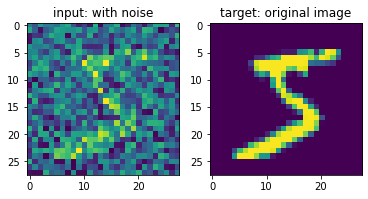

In [3]:
# visualize inputs (with noise) and targets (original image) of dataset
img = tf.reshape(x_train[0], [28,28])
target = tf.reshape(y_train[0], [28,28])

plt.subplot(121)
plt.imshow(img)
plt.title("input: with noise")

plt.subplot(122)
plt.imshow(target)
plt.title("target: original image")
plt.show()

In [4]:
class Encoder(tf.keras.Model):
  
    def __init__(self):
        super().__init__()
      
        # first convolution
        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="valid", activation='relu'))       
        self.layer1.add(tf.keras.layers.BatchNormalization())

        # second convolution
        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="valid", activation='relu'))
        self.layer2.add(tf.keras.layers.BatchNormalization())

        # embedding to shape 10
        self.embedding = tf.keras.Sequential()
        self.embedding.add(tf.keras.layers.Flatten())
        self.embedding.add(tf.keras.layers.Dense(10, activation="relu"))
    
    @tf.function
    def call(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.embedding(x)

        return x

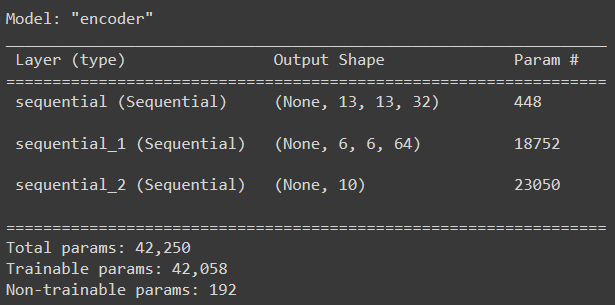

In [15]:
class Decoder(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        # reshape to get 3 dimensions
        self.reshape = tf.keras.Sequential()
        self.reshape.add(tf.keras.layers.Dense(36))
        self.reshape.add(tf.keras.layers.Reshape((6,6,1)))

        # first transpose convolution
        self.layer1 = tf.keras.Sequential()
        self.layer1.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="valid", activation='relu'))       
        self.layer1.add(tf.keras.layers.BatchNormalization())
        
        # second transpose convolution
        self.layer2 = tf.keras.Sequential()
        self.layer2.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="valid", activation='relu'))
        self.layer2.add(tf.keras.layers.BatchNormalization())
        
        # third transpose convolution
        self.layer3 = tf.keras.Sequential()
        self.layer3.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="valid", activation='relu'))
        self.layer3.add(tf.keras.layers.BatchNormalization())

        # "normal" convolution to get shape of image as output
        self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=2, padding="same", activation="sigmoid")

    @tf.function
    def call(self, x):

        x = self.reshape(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        
        return x

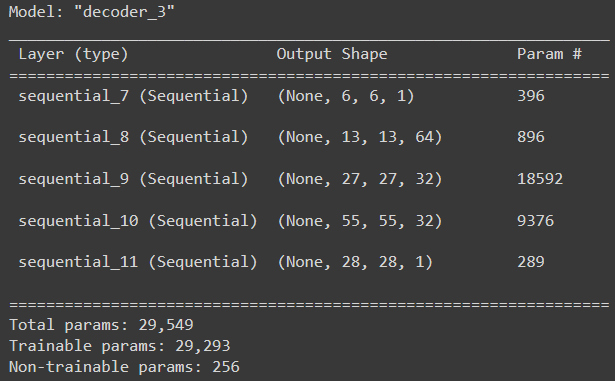

In [7]:
class Autoencoder(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]
      
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        # for visualizing sample of images while training
        self.counter = 0


    def call(self, x, training=False):
        
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    
    def train_step(self, data):
        img, target = data
        
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.compiled_loss(target, output, regularization_losses=self.losses)

            # save every 500th training batch
            if self.counter%500 == 0:
                train_pred.append(output)
        self.counter += 1

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

    
    def test_step(self, data):
        img, target = data

        output = self(img, training=False)
        loss = self.compiled_loss(target, output, regularization_losses=self.losses)
        
        # save every 100th test batch
        if self.counter%100 == 0:
            test_pred.append(output)
        self.counter += 1

        self.metrics[0].update_state(loss)
        
        return {m.name : m.result() for m in self.metrics}

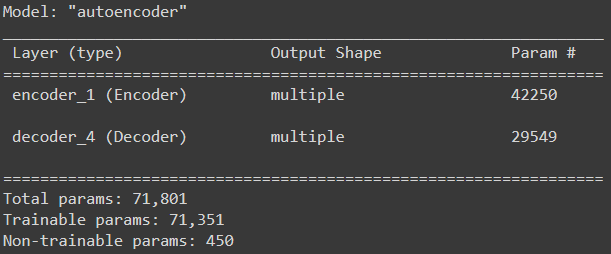

In [17]:
# lists for visualization of sample outputs
train_pred = []
test_pred = []

# instantiate and compile model with its hyperparameters
model = Autoencoder()
model.compile(optimizer="adam", loss="mse", run_eagerly=True)

# build the model and show summay
#model(tf.keras.Input((28,28,1)));
#model.summary()
 
# train model on data
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 66s 30ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1875/1875 [==============================] - 50s 26ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0000e+00 - val_loss: 0.0

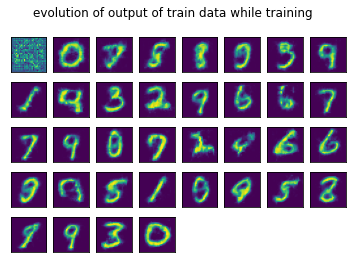

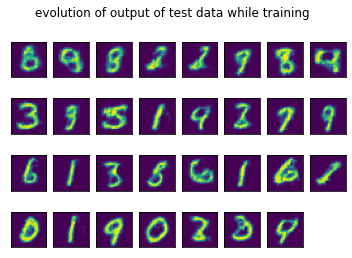

In [21]:
# visualize samples of output images during the training 

# take the first image of the saved batches and change dimensions
train_images = []
for batch in train_pred:
    train_images.append(tf.reshape(batch[0], [28,28]))
test_images = []
for batch in test_pred:
    test_images.append(tf.reshape(batch[0], [28,28]))

# plot the sampled images from training
for i in range(0,len(train_images)-2):
    plt.subplot(5,8,i+1)
    plt.imshow(train_images[i])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
plt.suptitle("evolution of output of train data while training")
plt.show()

# plot the sampled images from testing
for i in range(0, len(test_images)):
    plt.subplot(4,8,i+1)
    plt.imshow(test_images[i])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
plt.suptitle("evolution of output of test data while training")
plt.show()

#2.4 Latent Space Analysis

In [22]:
# preprocess test data again with original labels as targets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

img_rows, img_cols , channels= 28,28,1

x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
x_test = x_test.astype("float32")/255
x_test += tf.random.uniform((x_test.shape), -1, 1)

# take only first 1000 datapoints
x_test = x_test[:1000]
y_test = y_test[:1000]

In [25]:
import numpy as np
import sklearn.manifold

# call the model's encoder on the test data
i = model.encoder(x_test)

# fit the TSNE on the encoders output
tsne = sklearn.manifold.TSNE(n_components=2)
x_embedded = tsne.fit_transform(i)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


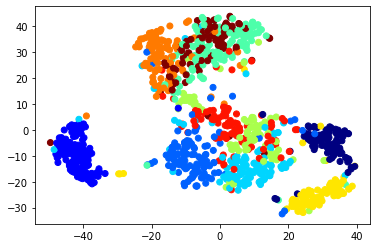

In [26]:
# plot the embeddings 
x1, x2 = map(list, zip(*x_embedded))
t = np.asarray(y_test)

# create colormap for the different labels
N = 10
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list("Custom cmap", cmaplist, cmap.N)

plt.figure()
plt.scatter(x1, x2, c=y_test, cmap=cmap)